## Jordi Blasco Lozano  
### Generación de grafos matcheados – Parte 1

- #### Librerías y Configuración Inicial

    En este bloque se importan las librerías necesarias para la visualización, generación de grafos, generación de triangulaciones y matcheos

    También se importa el módulo **DataLoader** para cargar nuestro dataset de paths.

In [1]:

import numpy as np
from PIL import Image
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay, distance
from scipy.optimize import linear_sum_assignment
import pandas as pd
import random
import logging
import matplotlib.colors as mcolors

from archivos.dataloader import DataLoader


- #### Configuración del logger
    En esta practica usaremos la librería logging para generar la información de depuración, de esta manera en vez de hacer `prints` normales, usaremos en livel de log de info para que en el momento de ejecución del programa sepamos que está haciendo nuestro programa en todo momento. Así quedará más clara la forma de funcionar del mismo

In [2]:
logging.basicConfig(
    level=logging.INFO,
    format='[%(asctime)s] %(levelname)s: %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
logger = logging.getLogger(__name__)
logger.info(f'Logging level: {logging.getLevelName(logger.getEffectiveLevel())}')



[2025-03-04 14:52:05] INFO: Logging level: INFO


- #### Carga del Dataset

    A continuación, se instancia la clase **DataLoader** para cargar los datos.
    El DataFrame resultante contiene todas las rutas de las imágenes y los archivos que contienen los keypoints, permitiendo acceder a la información de cada categoría.

In [3]:
# Instanciar el DataLoader y cargar los dataframes
dl = DataLoader()
dlf = dl.load_data()

- #### Carga de imagenes y plotteo de par de Imagenes 
    En `load_and_preprocess_images()` redimensionaremos las imágenes, indicando en que fila del dataset correspondiente buscar, de esta forma encontraremos las imagenes y puntos correspondientes y las devolveremos todo redimensionado

    Usaremos otra función para cargar los keypoints `load_keypoints_from_row()` y hacer más ligera la ejecución final ya que solo necesitaremos estos puntos. Sería poco practico cargarlo todo si no lo vamos a usar.

    Usaremos `visualize_combined()` para plotear cada par de imagenes que obtendrá como parámetros las imágenes, los puntos, las aristas y una matriz de maching para comprobar si los keypoints de las dos imagenes coinciden y así mostrar la linea roja o verde

In [4]:


def load_and_preprocess_images(row1, row2, target_size=(512,512)):
    """
    Carga y redimensiona dos imágenes junto a sus keypoints a partir de las filas de paths escogidas anteriormente.
    """

    img_path1 = row1['img']
    img_path2 = row2['img']
    mat_path1 = row1['mat']
    mat_path2 = row2['mat']


    img1 = Image.open(img_path1)
    img2 = Image.open(img_path2)
    mat_data1 = sio.loadmat(mat_path1)
    mat_data2 = sio.loadmat(mat_path2)
    kpts1 = np.array(mat_data1['pts_coord'])
    kpts2 = np.array(mat_data2['pts_coord'])
    
    # Ajustar los keypoints al nuevo tamaño
    orig_size1 = img1.size
    orig_size2 = img2.size
    kpts1[0] = kpts1[0] * target_size[0] / orig_size1[0]
    kpts1[1] = kpts1[1] * target_size[1] / orig_size1[1]
    kpts2[0] = kpts2[0] * target_size[0] / orig_size2[0]
    kpts2[1] = kpts2[1] * target_size[1] / orig_size2[1]
    
    img1 = img1.resize(target_size, resample=Image.BILINEAR)
    img2 = img2.resize(target_size, resample=Image.BILINEAR)
    
    return img1, img2, kpts1, kpts2
                               

def load_keypoints_from_row(row1, row2):

    mat_path1 = row1['mat']
    mat_path2 = row2['mat']

    kpts1 = np.array(sio.loadmat(mat_path1)['pts_coord'])   
    kpts2 = np.array(sio.loadmat(mat_path2)['pts_coord'])

    return kpts1 , kpts2

def visualize_combined(img1, img2, kpts1, kpts2, adj_matrix1, adj_matrix2, matching):
    """
    Visualiza de forma combinada dos imágenes, mostrando sus keypoints, grafos de Delaunay y correspondencias (matching).

    La función crea una imagen compuesta colocando las dos imágenes lado a lado. Sobre dicha imagen se dibujan:
      - El grafo de Delaunay para cada imagen, utilizando la matriz de adyacencia (adj_matrix1 y adj_matrix2).
      - Los keypoints detectados sobre cada imagen.
      - Las líneas de matching entre los keypoints de ambas imágenes, donde las correspondencias correctas
        (cuando el índice del keypoint coincide en ambas imágenes) se muestran en verde y las incorrectas en rojo.

    Parámetros:
      img1, img2 Imágenes a visualizar, en formato numpy.ndarray(RGB).
      kpts1, kpts2: Keypoints de las imágenes, en formato numpy.ndarray de tamaño (2, N). ejemplo: [[x1, x2, ..., xN], [y1, y2, , yN]]
      adj_matrix1, adj_matrix2: Matrices de adyacencia de los grafos de Delaunay. ejemplo: [[0, 1, 0], [1, 0, 1], [0, 1, 0]], (las aristas que conectan los keypoints)
      matching: Matriz binaria de tamaño (N, N) que indica las correspondencias entre los keypoints de ambas imágenes. 1 si hay correspondencia, 0 si no. ejemplo: [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
    """

    
    # obtenemos las dimensiones (altura y ancho) de ambas imágenes
    h1, w1 = np.array(img1).shape[:2]  
    h2, w2 = np.array(img2).shape[:2]  

    # creamos una imagen compuesta donde se ubicarán ambas imágenes una al lado de la otra.
    # donde la altura de la imagen compuesta será mayor de las dos, y el ancho la suma de ambos anchos.
    composite_img = np.zeros((max(h1, h2), w1 + w2, 3), dtype=np.uint8)
    composite_img[:h1, :w1, :] = img1  # colocamos la primera imagen en la parte izquierda
    composite_img[:h2, w1:w1+w2, :] = img2  # colocamos la segunda imagen en la parte derecha

    # desplazamos los keypoints de la segunda imagen para que se sitúen en la imagen compuesta.
    # y realizamos una copia para no modificar el original y se suma el ancho de la primera imagen a las coordenadas x.
    kpts2_shifted = kpts2.copy()
    kpts2_shifted[0, :] += w1


    plt.figure(figsize=(10, 10))
    plt.imshow(composite_img)


    color = mcolors.CSS4_COLORS['yellow']

    # Primero dibujamos los grafos de Delaunay para ambas imágenes:
    # Se hace uso de las matrices de adyacencia (adj_matrix1 y adj_matrix2) para saber qué keypoints se conectan.
    # Se itera de forma simultánea sobre los keypoints originales (para img1) y los keypoints desplazados (para img2).
    for kpts, adj_matrix in zip([kpts1, kpts2_shifted], [adj_matrix1, adj_matrix2]):
        N = kpts.shape[1]  # Número de keypoints en la imagen actual
        # iteramos sobre cada par de keypoints sin repetir conexiones
        for i in range(N):
            for j in range(i+1, N):
                if adj_matrix[i, j]:
                    # dibujamos una línea entre los keypoints conectados
                    plt.plot([kpts[0, i], kpts[0, j]], [kpts[1, i], kpts[1, j]], '-', color=color, linewidth=1)
        # por ultimo dibujamos los keypoints como puntos sobre la imagen
        plt.scatter(kpts[0], kpts[1], c=color, edgecolors='w', s=80)

    # Segundo dibujamos el matching entre keypoints de ambas imágenes
    # Se localizan los índices de los keypoints que han sido emparejados según la matriz 'matching'
    row_ind, col_ind = np.where(matching == 1)
    for r, c in zip(row_ind, col_ind):
        # Extraemos las coordenadas (x, y) de los keypoints en la primera imagen y en la segunda imagen desplazada
        x1, y1 = kpts1[:, r]
        x2, y2 = kpts2_shifted[:, c]
        # Si el índice coincide, se dibuja la línea de color lima, si no se dibuja en rojo
        if r == c:
            plt.plot([x1, x2], [y1, y2], '-', color=mcolors.CSS4_COLORS['lime'], linewidth=1)
        else:
            # De lo contrario, la línea se dibuja en rojo para indicar un error en la correspondencia
            plt.plot([x1, x2], [y1, y2], '-', color='r' , linewidth=1)


    plt.title("Matching y Triangulación Delaunay")
    plt.axis("off")
    plt.show()

- #### Funcion Delaunay
    Como he explicado en la practica anterior la manera mas sencilla de conectar puntos de un grafo formando triangulos uniformes es usando la `Triangulacion de Delaunay` esto se consigue hacer de la siguiente manera:

    Primero probamos todas las combinaciones posibles juntando 3 puntos formando triangulos, a todos estos triangulos les dibujamos un circulo que pase por los tres vertices, si hay algun punto dentro de este circulo el triangulo se descarta, pero, si no hay ningun círculo extraemos las aristas para formar el grafo final.



In [5]:

def delaunay_triangulation(kpts):
    """
    Construye un grafo usando Delaunay triangulation.
    
    Parámetros:
        - kpts: np.array de shape (2, N) con las coordenadas de los keypoints.
        ejemplo: kpts = np.array([[x1, x2, ..., xN], [y1, y2, ..., yN]])
    
    Devuelve:
        - edges: Lista de tuplas (i, j) representando las aristas del grafo. ejem: [(0, 1), (1, 2), ...]
    """
    pts = kpts.T
    tri = Delaunay(pts)
    N = pts.shape[0]
    A = np.zeros((N, N))
    for simplex in tri.simplices:
        for i in range(len(simplex)):
            for j in range(i+1, len(simplex)):
                A[simplex[i], simplex[j]] = 1
                A[simplex[j], simplex[i]] = 1
    return A



- #### Función Simple_spatial_matching
    Por otra parte la función `simple_spatial_matching` realiza un emparejamiento simple entre los keypoints de dos imágenes, basándose en la distancia euclidiana entre ellos.

    1. **Se calcula la matriz de distancias:**  
    Se computa una matriz en la que cada elemento representa la distancia euclidiana entre un keypoint de la primera imagen y otro de la segunda imagen.

    2. **Resolución del problema de asignación:**  
    Utilizando la matriz de distancias como matriz de costos, se aplica el algoritmo de asignación húngaro. Este algoritmo encuentra la asignación de pares de keypoints que minimiza el costo total.  
    *Ejemplo:*  
    Para la siguiente matriz de costos:  
        ```
        [[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]]
        ```  
        Una solución posible es la asignación:  
        - El keypoint 0 de la primera imagen se empareja con el keypoint 0 de la segunda (costo = 1).  
        - El keypoint 1 se empareja con el keypoint 1 (costo = 5).  
        - El keypoint 2 se empareja con el keypoint 2 (costo = 9).  
        
        Esta asignación se representa como `[(0, 0), (1, 1), (2, 2)]`.

    3. **Salida:**  
    Se devuelve una matriz binaria de tamaño (N, N), donde N es el número de keypoints, que indica las correspondencias encontradas. En esta matriz, un valor de 1 en la posición (i, j) significa que el keypoint i de la primera imagen se ha emparejado con el keypoint j de la segunda. 
    
        `ejemplo: [[1, 0, 0], [0, 1, 0], [0, 0, 1]]`





In [6]:

def simple_spatial_matching(kpts1, kpts2):
    """
    Realiza un emparejamiento simple entre los keypoints de dos imágenes, basado en la distancia euclidiana entre ellos.

    Parámetros:
        - kpts1, kpts2: np.array de shape (2, N) con las coordenadas de los keypoints de ambas imágenes. ejemplo: kpts1 = np.array([[x1, x2, ..., xN], [y1, y2, ..., yN]])

    Devuelve:
        - matching: np.array de shape (N, N) con las correspondencias entre keypoints. 1 si hay correspondencia, 0 si no. ejemplo: [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
    """

    # Paso 1: Calcular la matriz de costos
    pts1 = kpts1.T
    pts2 = kpts2.T
    cost_matrix = distance.cdist(pts1, pts2, metric="euclidean")

    # Paso 2: Realizar la asignación de pares de keypoints minimizando la suma de las distancias euclidianas
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    # Paso 3: Crear la matriz de correspondencias final
    matching = np.zeros(cost_matrix.shape, dtype=int)
    matching[row_ind, col_ind] = 1
    
    return matching


- #### Computación y Evaluación del Matching

    Finalmente, para poner en práctica toda la teoría anterior, he hecho dos funciones:  
- `evaluate_matching_precision()`, que evalúa la precisión de los matcheos.  
-   `compute_precision_for_categories()`, la función "main", la cual selecciona un par aleatorio de imágenes para su visualización triangulizada y matcheada. Posteriormente, creamos un bucle anidado para pasar por todos los grafos de cada categoria de par en par, cargamos los keypoints y usamos el `simple_spatial_matching()` con el algoritmo hungaro para generar los matcheos y finalmente evaluarlos. Los resultados finales se obtienen guardando cada evaluacion en una lista y calculando la media y la desviación estandar de la misma. Los `final_results` se guardan en un `pandas.df` para mostrarse, el archivo csv lo guardaremos como `baseline_results.csv` en la siguiente practica para no tener que guardarlo dos veces.


In [7]:



def evaluate_matching_precision(kpts1, matching):
    """
    Calcula la precisión del emparejamiento de keypoints basado en una matriz binaria de matching.

    Parámetros:
    -----------
    kpts1 : np.array de tamaño (N, 2). ejemplo [[x1, x2, ..., xN], [y1, y2, ..., yN]]

    matching : np.array de tamaño (N, N)
        Matriz binaria donde `matching[i, j] = 1` indica que el keypoint `i` de la primera imagen 
        ha sido emparejado con el keypoint `j` de la segunda imagen.

    Proceso:
    --------
    1. Se obtiene `N`, el número total de keypoints en la primera imagen.
    2. Se extraen los índices `(i, j)` donde `matching[i, j] == 1`, es decir, los emparejamientos detectados.
    3. Se cuentan los emparejamientos correctos, que son aquellos donde `i == j`, es decir, los que coinciden con la diagonal de la matriz (se asume que este es el emparejamiento ideal).
    4. Se calcula la precisión como la fracción de emparejamientos correctos sobre el total de keypoints `N`.
       - Si `N = 0`, se devuelve `0` para evitar división por cero.

    Retorna:
    --------
    float:
        Precisión del emparejamiento, en el rango [0, 1].

    Ejemplo:
    --------
    import numpy as np
    kpts1 = np.array([[10, 10], [20, 20], [30, 30]])  # 3 keypoints en la imagen 1


    matching_1 = np.array([
         [1, 0, 0],  
         [0, 1, 0],  
         [0, 0, 1]]) 

     # Emparejamiento perfecto
    evaluate_matching_precision(kpts1, matching_1) = 1.0

    matching_2 = np.array([
        [0, 1, 0],  
        [1, 0, 0],  
        [0, 0, 1]])  
    
     # Solo el tercer emparejamiento es correcto
    evaluate_matching_precision(kpts1, matching_2) = 0.3333
    """
    N = kpts1.shape[1]
    row_ind, col_ind = np.where(matching == 1)
    correct = np.sum(row_ind == col_ind)
    return correct / N if N != 0 else 0

def compute_precision_for_categories(dlf):
    """
    Evalúa la precisión del emparejamiento de keypoints en distintas categorías de imágenes 
    y guarda los resultados en un archivo CSV.

    Parámetros:
    -----------
    dlf : pandas.df de paths con las imágenes y keypoints de cada categoría.

    Proceso:
    --------
    1. Para cada categoría en `dlf` se selecciona un par aleatorio de imagenes y se visualiza el emparejamiento de sus keypoints.

    2. Se comparan todas los grafos de la categoría entre sí (par a par, sin repetir combinaciones) y se calcula la precisión del emparejamiento de keypoints para cada par usando el simple_spatial_matching() y posteriormente se avaluan los emparejamientos con evaluate_matching_precision().
       
    3. Se calculan la media y la desviación estándar de la precisión dentro de la categoría.
        - Se almacenan los resultados en una lista y, al finalizar, se genera un pandas.df con:
       - `Category`: Nombre de la categoría.
       - `Mean_Accuracy`: Precisión media del emparejamiento en la categoría.
       - `Std_Deviation`: Desviación estándar de la precisión en la categoría.
       - `Number_of_Images`: Número de imágenes evaluadas en la categoría.

    4. Se guarda en un pandas.df y se devuelve.

    Retorna:
    --------
    pandas.df: con las métricas de precisión para cada categoría analizada.

    """
    
    
    overall_results = [] 
    for cat_name, cat_df in dlf.items():

        # Paso 1: Visualizar un par aleatorio de imágenes y sus keypoints
        sample = cat_df.sample(2)
        row1 = sample.iloc[0]
        row2 = sample.iloc[1]
         

        img1, img2, kpts1, kpts2 = load_and_preprocess_images(row1, row2)

        # Calculamos la triangulación de Delaunay 
        adj1 = delaunay_triangulation(kpts1)
        adj2 = delaunay_triangulation(kpts2)

        # Realizamos el matcheo de keypoints
        matching = simple_spatial_matching(kpts1, kpts2)
        logger.info(f"Visualizando par aleatorio para {cat_name}")

        # Visualizamos las imágenes y keypoints
        visualize_combined(img1, img2, kpts1, kpts2, adj1, adj2, matching)
        
        # Paso 2: Calculamos la precisión del emparejamiento para todas las combinaciones de grafos en la categoría
        precisions = []
        n = len(cat_df)
        for i in range(n - 1):
            for j in range(i + 1, n):
                row_a = cat_df.iloc[i]
                row_b = cat_df.iloc[j]

                kpts_a, kpts_b = load_keypoints_from_row(row_a, row_b)
                matching_pair = simple_spatial_matching(kpts_a, kpts_b)
                prec = evaluate_matching_precision(kpts_a, matching_pair)
                precisions.append(prec)
        
        # Paso 3: calculamos la precisión media y desviación estándar de la categoría
        media = np.mean(precisions)
        std = np.std(precisions)
        
        # Mostramos los resultados en consola
        logger.info(f"Categoría {cat_name.capitalize()}: Precisión media = {media:.4f}, Desviación = {std:.4f}")
        logger.info(f"Resultados procesados para {cat_name} con {len(cat_df)} imágenes")
        
        
        overall_results.append({
            "Category": cat_name,
            "Mean_Accuracy": round(media, 4),
            "Std_Deviation": round(std, 4),
            "Number_of_Images": n
        })
    
    # Paso 4: guardamos los resultados en un pandas.df y exportamos a CSV
    overall_df = pd.DataFrame(overall_results)

    return overall_df

[2025-03-04 14:52:06] INFO: Visualizando par aleatorio para car


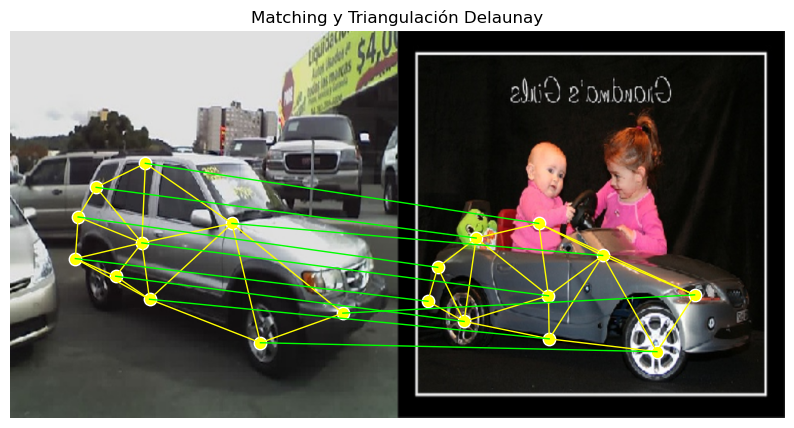

[2025-03-04 14:52:06] INFO: Categoría Car: Precisión media = 0.7118, Desviación = 0.3007
[2025-03-04 14:52:06] INFO: Resultados procesados para car con 40 imágenes
[2025-03-04 14:52:06] INFO: Visualizando par aleatorio para duck


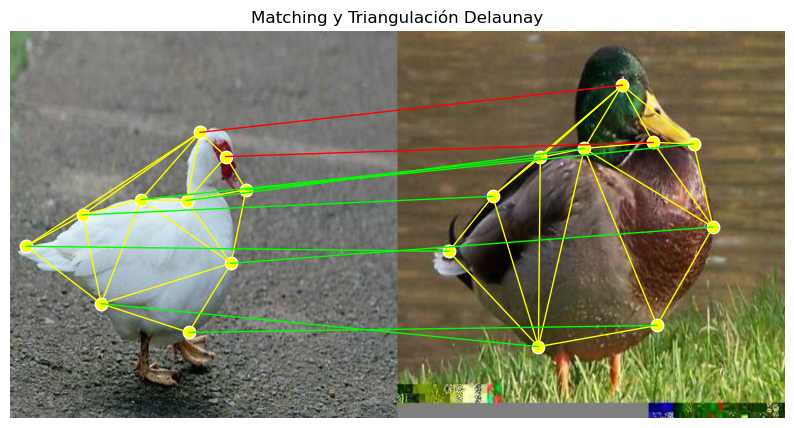

[2025-03-04 14:52:07] INFO: Categoría Duck: Precisión media = 0.6753, Desviación = 0.2878
[2025-03-04 14:52:07] INFO: Resultados procesados para duck con 50 imágenes
[2025-03-04 14:52:07] INFO: Visualizando par aleatorio para face


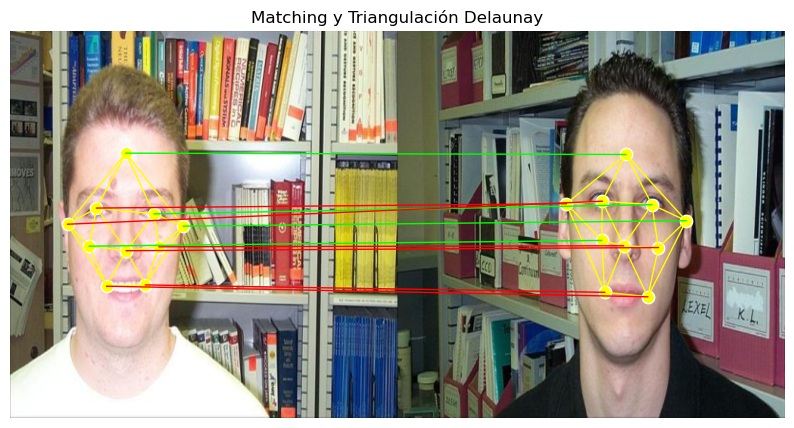

[2025-03-04 14:52:10] INFO: Categoría Face: Precisión media = 0.8452, Desviación = 0.1879
[2025-03-04 14:52:10] INFO: Resultados procesados para face con 109 imágenes
[2025-03-04 14:52:10] INFO: Visualizando par aleatorio para motorbike


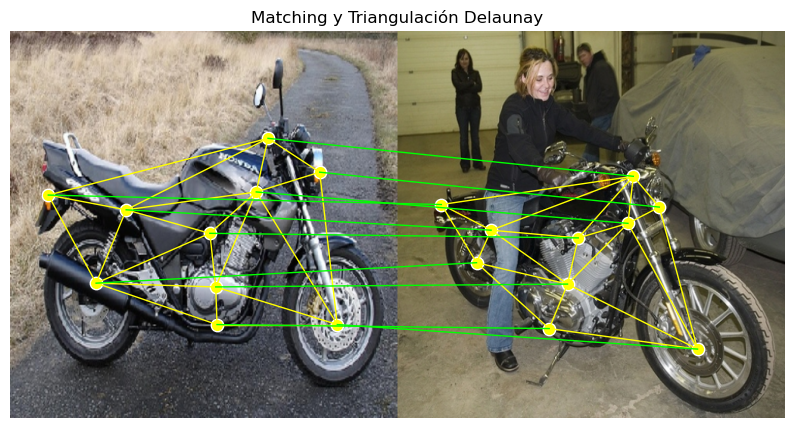

[2025-03-04 14:52:11] INFO: Categoría Motorbike: Precisión media = 0.8265, Desviación = 0.2302
[2025-03-04 14:52:11] INFO: Resultados procesados para motorbike con 40 imágenes
[2025-03-04 14:52:11] INFO: Visualizando par aleatorio para winebottle


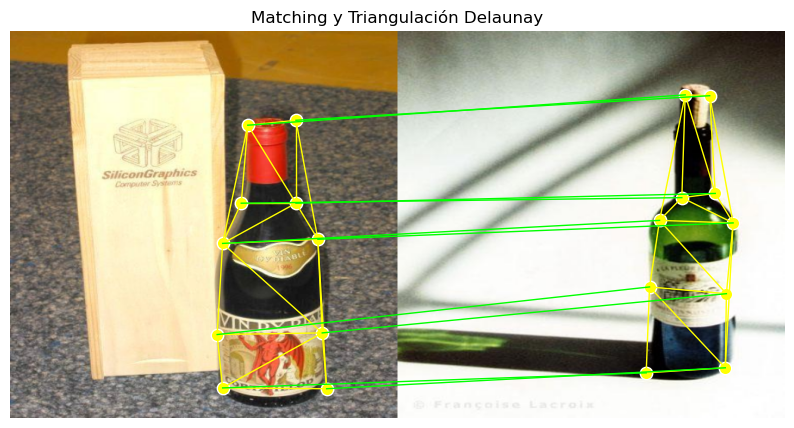

[2025-03-04 14:52:12] INFO: Categoría Winebottle: Precisión media = 0.8826, Desviación = 0.1792
[2025-03-04 14:52:12] INFO: Resultados procesados para winebottle con 66 imágenes


In [8]:
final_results = compute_precision_for_categories(dlf)

## RESULTADOS FINALES


In [9]:
final_results

,Category,Mean_Accuracy,Std_Deviation,Number_of_Images
0,car,0.7118,0.3007,40
1,duck,0.6753,0.2878,50
2,face,0.8452,0.1879,109
3,motorbike,0.8265,0.2302,40
4,winebottle,0.8826,0.1792,66
